In [1]:
!wget -O data.zip http://51.91.120.89/extras/transfer_data.zip

--2022-06-12 09:43:10--  http://51.91.120.89/extras/transfer_data.zip
Connecting to 51.91.120.89:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96524975 (92M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  92.05M  11.7MB/s    in 8.6s    

2022-06-12 09:43:19 (10.7 MB/s) - ‘data.zip’ saved [96524975/96524975]



In [2]:
!unzip -q data.zip

warning [data.zip]:  932228 extra bytes at beginning or within zipfile
  (attempting to process anyway)


In [3]:
!unzip -q dataset2.zip

In [4]:
import glob, os, shutil

In [5]:
types = [
  ("Cloudy", "cloud*.*") , ("Rainy","rain*.*") , ("Shiny","shin*.*"), ("Sunrise","sunrise*.*")       
]

shutil.rmtree("dataset", ignore_errors=True)
for folder_name, file_mask in types:
  os.makedirs(f"dataset/Train/{folder_name}")
  os.makedirs(f"dataset/Test/{folder_name}")

  files = sorted( glob.glob(f"dataset2/{file_mask}") )
  train_qnty = int(len(files)*0.8)

  [ shutil.copy(file, f"dataset/Train/{folder_name}")  for file in files[:train_qnty] ]
  [ shutil.copy(file, f"dataset/Test/{folder_name}")  for file in files[train_qnty:] ]
  print(folder_name, file_mask, len(files), sep=" : ")

Cloudy : cloud*.* : 300
Rainy : rain*.* : 215
Shiny : shin*.* : 253
Sunrise : sunrise*.* : 357


In [6]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [7]:
!wget -O obraz.jpg https://www.rynek-lotniczy.pl/img/20190216031910a380parispbozyk2.jpg_678-443.jpg

--2022-06-12 09:43:23--  https://www.rynek-lotniczy.pl/img/20190216031910a380parispbozyk2.jpg_678-443.jpg
Resolving www.rynek-lotniczy.pl (www.rynek-lotniczy.pl)... 195.54.50.245
Connecting to www.rynek-lotniczy.pl (www.rynek-lotniczy.pl)|195.54.50.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25513 (25K) [image/jpeg]
Saving to: ‘obraz.jpg’

obraz.jpg           100%[===================>]  24.92K  --.-KB/s    in 0.1s    

2022-06-12 09:43:24 (204 KB/s) - ‘obraz.jpg’ saved [25513/25513]



In [8]:
img = load_img("obraz.jpg", target_size=(224,224))
x = img_to_array(img)
x = x.reshape(1, 224, 224, 3)
x.shape

(1, 224, 224, 3)

In [9]:
model = VGG16()
predict = model.predict( preprocess_input(x) )

553476096/553467096 [==============================] - 3s 0us/step


In [10]:
decode_predictions(predict)

49152/35363 [=========================================] - 0s 0us/step


[[('n02690373', 'airliner', 0.88385886),
  ('n04592741', 'wing', 0.108112216),
  ('n04266014', 'space_shuttle', 0.004889028),
  ('n04552348', 'warplane', 0.0024180666),
  ('n02692877', 'airship', 0.00036566862)]]

In [11]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# tworzymy nową siec na bazie oryginalnej
model = VGG16(include_top=False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
# wyłączenie z treningu istniejących już warstw
for layer in model.layers:
  layer.trainable = False

In [14]:
# adaptacja wyjścia istniejącej sieci do nowej liczby kategorii wyjściowych
hidden = Flatten()(model.output)
outputs = Dense(4, activation="softmax")(hidden)

In [15]:
# tworzymy nowy model sieci na podstawie starych warstw i nowego wyjścia
model_new = Model(inputs=model.input, outputs=outputs)
model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
model_new.compile(loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
train_data_gen = ImageDataGenerator(rescale=1/255, horizontal_flip=True, vertical_flip=True, zoom_range=0.7, shear_range=0.5)
test_data_gen = ImageDataGenerator(rescale=1/255)

In [23]:
train_data = train_data_gen.flow_from_directory("dataset/Train", target_size=(224,224), class_mode="categorical" )
test_data = test_data_gen.flow_from_directory("dataset/Test", target_size=(224,224), class_mode="categorical" )

Found 899 images belonging to 4 classes.
Found 226 images belonging to 4 classes.


In [ ]:
result = model_new.fit_generator(train_data, epochs=100, validation_data=test_data)

In [25]:
test_data.class_indices

{'Cloudy': 0, 'Rainy': 1, 'Shiny': 2, 'Sunrise': 3}

In [27]:
!wget -O lt.h5 http://51.91.120.89/extras/cnn/vgg16-v1.h5

--2022-06-12 10:14:33--  http://51.91.120.89/extras/cnn/vgg16-v1.h5
Connecting to 51.91.120.89:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60143304 (57M)
Saving to: ‘lt.h5’

lt.h5               100%[===================>]  57.36M  8.81MB/s    in 6.6s    

2022-06-12 10:14:40 (8.71 MB/s) - ‘lt.h5’ saved [60143304/60143304]



In [28]:
from tensorflow.keras.models import load_model
model = load_model("lt.h5")

In [ ]:
model.summary()

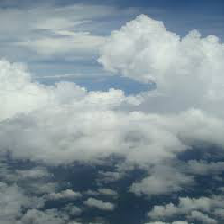

In [43]:
img = load_img("/content/dataset/Test/Cloudy/cloudy46.jpg", target_size=(224,224))
x = img_to_array(img)
x = x.reshape(1, 224, 224, 3)
img

In [44]:
predict = model.predict( preprocess_input(x) )
predict

array([[9.64279e-34, 0.00000e+00, 0.00000e+00, 1.00000e+00]],
      dtype=float32)